In [1]:
import wave
import matplotlib.pyplot as plt
import numpy as np

import scipy as sp
from scipy import signal

In [2]:
def read_wave(file_name):
    file = wave.open(file_name,'rb')
    params = file.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
#     print("nchannels:", nchannels)
#     print("sampwidth:", sampwidth)
#     print("framerate:", framerate)
#     print("nframes:", nframes)
    strData = file.readframes(nframes)  # encoded in bytes
    file.close()
    waveData = np.frombuffer(strData, dtype=np.int16)  # convert to int16
    return waveData, framerate, nframes


def plot_wave(signal, framerate, title):
    time = np.arange(0, signal.size) * (1.0 / framerate)
    plt.figure(figsize=(6, 3))
    plt.plot(time, signal)
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid('on')
#     plt.savefig('./Experiment1_fig/{}.png'.format(title))
    plt.show()

def specgram_wave(signal, framerate):
    plt.specgram(signal, Fs=framerate, cmap="rainbow")
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.title("Spectrogram")
#     plt.savefig('./Experiment1_fig/Spectrogram.png')
    plt.show()
    
def psd_wave(signal, framerate):
    plt.psd(signal, Fs=framerate)
#     plt.savefig('./Experiment1_fig/psd.png')
    plt.show()
    
# Fast Fourier Transform at selected time interval
def fft_wave(signal, framerate, time_interval):
    time = np.arange(0, signal.size) * (1.0 / framerate)
    
    plt.subplot(2,1,1)
    plt.plot(time, signal)
    plt.fill_between(time_interval,np.min(signal),np.max(signal),color="pink")
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude")
    plt.grid('on')
    
    
    start_time, end_time = time_interval
#     start_index = np.where(time == start_time)
    select_time = time[(time>=start_time) & (time<=end_time)]
    select_signal = signal[(time>=start_time) & (time<=end_time)]
    fft_signal = np.fft.fft(select_signal)
    
    t = np.arange(select_signal.size)
    freq = np.fft.fftfreq(t.shape[-1])
    freq_in_Hz = abs(freq * framerate)
    
    plt.subplot(2,1,2)
    plt.plot(freq_in_Hz,np.abs(fft_signal))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (a.u.)")
    
#     fft_signal = np.abs(fft_signal)
#     freq_in_Hz = np.fft.fftfreq(select_signal.size,1/framerate)
#     plt.plot(freq_in_Hz[0:select_signal.size//2], (2/select_signal.size)*fft_signal[0:select_signal.size//2])
    
    plt.show()
    return fft_signal, freq_in_Hz


# remove DC component
def remove_mean(signal):
    return signal - np.mean(signal)

# rectified
def rectified(signal):
    return np.abs(signal)

# 4th order bandpass filter
def bandpass_filter(signal, framerate, low, high):
    b, a = sp.signal.butter(4, [low/(framerate/2), high/(framerate/2)], btype='bandpass')
    signal_filtered = sp.signal.filtfilt(b, a, signal)
    return signal_filtered

# 4th order bandstop filter
def bandstop_filter(signal, framerate, low, high):
    b, a = sp.signal.butter(4, [low/(framerate/2), high/(framerate/2)], btype='bandstop')
    signal_filtered = sp.signal.filtfilt(b, a, signal)
    return signal_filtered

# 4th order lowpass filter
def lowpass_filter(signal, framerate, cutoff):
    b, a = sp.signal.butter(4, cutoff/(framerate/2), btype='lowpass')
    signal_filtered = sp.signal.filtfilt(b, a, signal)
    return signal_filtered

# notch filter
def notch_filter(signal, framerate, f0):
    b, a = sp.signal.iirnotch(f0, Q=30, fs=framerate)
    signal_filtered = sp.signal.filtfilt(b, a, signal)
    return signal_filtered

[-159 -141  -93 ...  305  235  180]


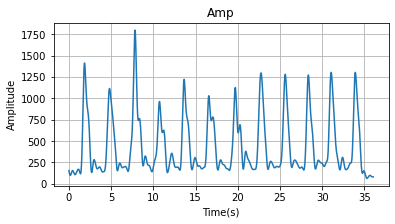

In [3]:
def EMG_amplitude(file_name):
    signal, framerate, nframes = read_wave(file_name)
    print(signal)
    
    signal_filtered = bandpass_filter(signal, framerate, 10, 500)
    signal_notch = notch_filter(signal_filtered, framerate, 50)
    signal_notch = notch_filter(signal_notch, framerate, 100)
    for electricity in range(50,701,50):
        signal_notch = notch_filter(signal_notch, framerate, electricity)
        
    
    signal_rectified = rectified(signal_notch)
    signal_box = lowpass_filter(signal_rectified,framerate, 2)
    #print(signal_box)
    #np.savetxt("./" + file_name + "_filtered.txt", signal_box)
    return signal_notch, signal_box, framerate

filtered, amplitude, framerate = EMG_amplitude("实验3-flexion.wav")

plot_wave(amplitude, framerate, "Amp")

In [4]:
import numpy as np
import wave
import os
import shutil

def segment_data(waveData, segment_size=2000, overlap_size=500):
    """
    Segments waveform data into NumPy arrays with segment_size data points,
    and a specified overlap between adjacent segments.
    """
    data_len = len(waveData)
    print("data_len=%d"%data_len)
    num_segments = int(np.ceil((data_len - segment_size) / overlap_size)) + 1
    print("num_segments=%d"%num_segments)
    segments = np.zeros((num_segments, segment_size), dtype=np.int16)
    for i in range(num_segments):
        start = i * overlap_size
        #print("start=%d"%start)
        end = start + segment_size
        #print("end=%d"%end)
        if end > data_len:
            segments[i, :data_len-start] = waveData[start:]
        else:
            segments[i, :] = waveData[start:end]
    return segments

def save_segments(segments, file_prefix):
    """
    Saves waveform data segments to multiple .txt files with the specified prefix.
    """
    for i, segment in enumerate(segments):
        filename = f"{file_prefix}_{i+1}.txt"
        #print(filename)
        np.savetxt(filename, segment, delimiter='\t', fmt='%d')
        #print("successful")
        
def classify(data_path, amp_path, save_path, threshold):
    files = os.listdir(amp_path)
    for file in files:
        if ".DS_Store" not in file:
            with open(amp_path + "/" +file, "rb") as f:
                '''
                signal = []
                for line in f:
                    try:
                        sample = float(line.strip())
                        signal.append(sample)
                    except ValueError:
                        pass
                '''
                signal = [float(line.strip()) for line in f]   
                action_count = sum(1 for sample in signal if sample > threshold)
                if action_count / len(signal) > 0.3: #规则是一段信号里面有30%的action就定义为动作电位，可以后续根据结果来调整
                    shutil.copyfile(data_path + "/" +file, save_path + "/action/" + file)
                else:
                    shutil.copyfile(data_path + "/" +file, save_path + "/rest/" + file)
        else:
            continue
    
        
if __name__ == '__main__':
    #分割波形
    data0, data0_amp, framerate0 = EMG_amplitude("实验3-flexion.wav")
    data1, data1_amp, framerate1 = EMG_amplitude("实验3-open hand.wav")
    data2, data2_amp, framerate2 = EMG_amplitude("实验3-punch.wav")
    
    segments0 = segment_data(data0, segment_size=2000, overlap_size=500)
    segments1 = segment_data(data1, segment_size=2000, overlap_size=500)
    segments2 = segment_data(data2, segment_size=2000, overlap_size=500)
    
    segments0_amp = segment_data(data0_amp, segment_size=2000, overlap_size=500)
    segments1_amp = segment_data(data1_amp, segment_size=2000, overlap_size=500)
    segments2_amp = segment_data(data2_amp, segment_size=2000, overlap_size=500)
    
    save_segments(segments0, './segment_flexion/segment')
    save_segments(segments1, './segment_openhand/segment')
    save_segments(segments2, './segment_punch/segment')
    
    save_segments(segments0_amp, './segment_flexion_amp/segment')
    save_segments(segments1_amp, './segment_openhand_amp/segment')
    save_segments(segments2_amp, './segment_punch_amp/segment')
    
    #label
    classify('./segment_flexion', './segment_flexion_amp', './flexion', 400)
    classify('./segment_openhand', './segment_openhand_amp', './openhand', 200)
    classify('./segment_punch', './segment_punch_amp', './punch', 400)

[-159 -141  -93 ...  305  235  180]
[-123 -490 -805 ... -138 -121 -120]
[ -12    6   -3 ... -832 -661 -523]
data_len=360422
num_segments=718
data_len=306766
num_segments=611
data_len=307211
num_segments=612
data_len=360422
num_segments=718
data_len=306766
num_segments=611
data_len=307211
num_segments=612
